# ARIMA Forecasting

## Inhalt


1. **Datenbankverbindung und Datenabruf:** Zuerst wurde eine Verbindung zu einer SQL Server-Datenbank hergestellt, und aus einer bestimmten Tabelle wurden Daten für ein ausgewähltes Unternehmen abgerufen und in einem DataFrame gespeichert.

2. **Datenvisualisierung:** Dann wurden die Schlusskurse ("Close") des Unternehmens über die Zeit in einem Liniendiagramm dargestellt.

3. **Zeitreihenanalyse:** Anschließend wurden verschiedene Zeitreihenanalysen durchgeführt, darunter eine saisonale Zerlegung, ein Autokorrelationsdiagramm und ein partielles Autokorrelationsdiagramm.

4. **Modellbildung und -anpassung:** Dann wurde ein ARIMA-Modell (Autoregressive Integrated Moving Average) mit Hilfe der Python-Bibliothek 'pmdarima' erstellt und an die Schlusskurse angepasst. Die optimalen Parameter für das ARIMA-Modell wurden ermittelt und ausgegeben.

5. **Vorhersagen:** Mit dem angepassten Modell wurden Vorhersagen für die zukünftigen Schlusskurse gemacht und visualisiert.

6. **Datenverarbeitung:** Das Daten-DataFrame wurde dann erweitert und manipuliert, um zusätzliche Informationen für die anschließende Speicherung in der Datenbank hinzuzufügen.

7. **Datenbankaktualisierung:** Die vorhergesagten Daten wurden mit einer existierenden Tabelle in der Datenbank zusammengeführt, Duplikate entfernt und die aktualisierten Daten in der Datenbank gespeichert.


## 1. Datenbankverbindung und Datenabruf

Zunächst wird eine Verbindung zu einer SQL Server-Datenbank hergestellt und es werden Aktiendaten für ein spezifisches Unternehmen extrahiert. Zur weiteren Bearbeitung wird eine Transformation der Daten angewandt.

In [1]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
# BITTE HIER DATUM UND COMPANY ÄNDERN
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2016-01-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-07-01"  # Enddatum, bis zu dem Daten überprüft werden sollen
company_name = "GOOG"  # nur AAPL, MSFT oder GOOG möglich // Name des Unternehmens, für das Daten geladen werden sollen

# Daten aus der Tabelle für das bestimmte Unternehmen in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ? AND Company = ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date, company_name))

# added
data["ID"] = data.index
data = data[["ID", "Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())


        ID       Date Company Type        Open        High         Low  \
1881  1881 2023-06-26    GOOG  ACT  121.466003  122.720001  118.989998   
1882  1882 2023-06-27    GOOG  ACT  117.839996  119.894997  116.910004   
1883  1883 2023-06-28    GOOG  ACT  117.959999  121.269997  117.599998   
1884  1884 2023-06-29    GOOG  ACT  120.089996  120.910004  119.209999   
1885  1885 2023-06-30    GOOG  ACT  121.099998  122.029999  120.879997   

           Close    Volume  
1881  119.089996  23185000  
1882  119.010002  27221700  
1883  121.080002  19753100  
1884  120.010002  18517500  
1885  120.970001  23865800  


## 2. Datenvisualisierung

Der historische Kursverlauf der Close-Werte wird in einem Liniendiagramm visualisiert.

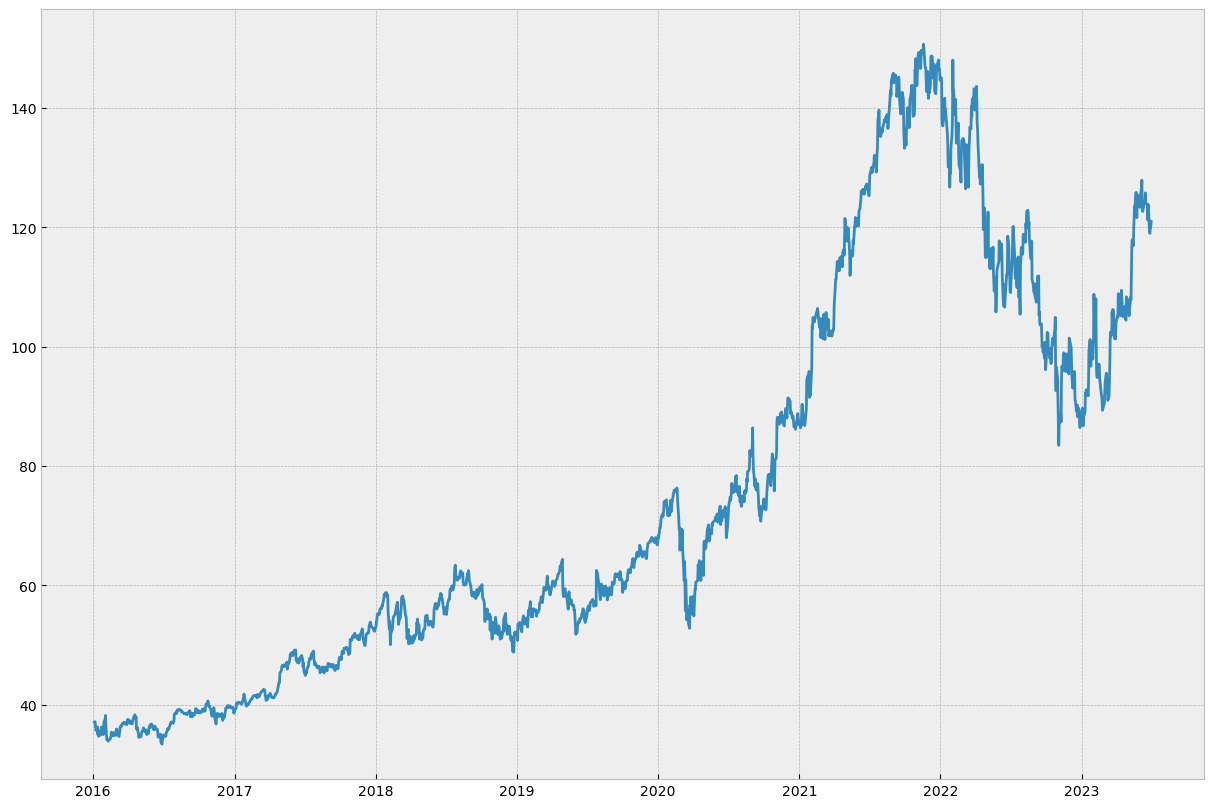

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

## 3. Zeitreihenanalyse

`seasonal_decompose` ist eine Funktion, die eine Zeitreihe in drei verschiedene Komponenten zerlegt:

- Trend: Die zugrundeliegende Tendenz der Zeitreihen. Dabei werden steigende und fallende Tendenzen abgebildet.
- Saisonalität: Periodische Schwankungen. Zum Beispiel könnte der Aktienkurs tendenziell während bestimmter Zeiten eines Jahres steigen oder fallen.
- Residual: Der Teil der Zeitreihe, der nicht durch Trend und Saisonalität erklärt werden kann.

Folgende Parameter werden verwendet:

- `data["Close"]`: Die zu analysierende Zeitreihe der Close-Werte
- `model='multiplicative'`: Das zu verwendende Modell für die Zerlegung. Ein multiplikatives Modell ist geeignet, wenn die Amplitude der saisonalen Schwankungen mit der Zeit zunimmt oder abnimmt.
- `period=30`: Die Länge des saisonalen Zyklus. In diesem Fall wird davon ausgegangen, dass sich die saisonalen Schwankungen alle 30 Tage wiederholen.

<Figure size 640x480 with 0 Axes>

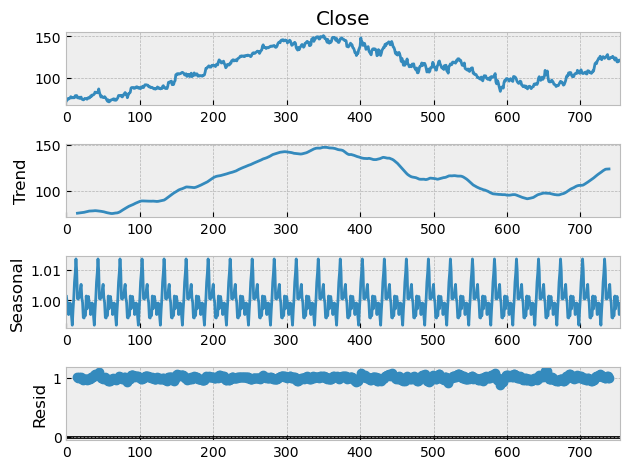

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot() 

Die Funktion `pd.plotting.autocorrelation_plot()` ist eine visuelle Hilfsmethode, um die Autokorrelation in einer Zeitreihe darzustellen. Autokorrelation, auch bekannt als serielle Korrelation, bezeichnet die Korrelation eines Elements in einer Serie mit anderen Elementen aus derselben Serie, die von früheren Zeitschritten stammen.

Das Autokorrelationsdiagramm hilft zu erkennen, ob es eine Muster oder eine Beziehung zwischen den Werten einer Zeitspanne gibt und den Werten aus vorherigen Zeitspannen.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

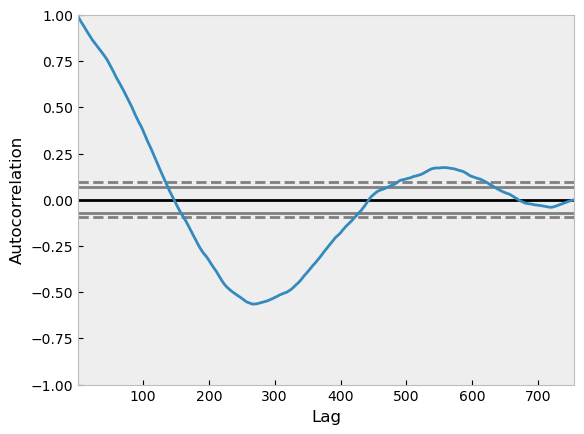

In [4]:
pd.plotting.autocorrelation_plot(data["Close"])

Die Funktion `plot_pacf` aus der `statsmodels.graphics.tsaplots` Bibliothek wird verwendet, um das partielle Autokorrelationsdiagramm für die gegebenen Zeitreihendaten zu erstellen. 

Ein Diagramm der partiellen Autokorrelation gibt Auskunft über die direkte Beziehung eines gegebenen Lags mit der aktuellen Zeitspanne, nachdem die Effekte aller kleineren Lags herausgerechnet wurden. 

Hier sind die Parameter, die in der Funktion verwendet werden:

- `data["Close"]`: Die zu analysierende Zeitreihe (in diesem Fall die Schlusskurse der Aktien).
- `lags=100`: Die Anzahl der Lags, die im Diagramm angezeigt werden sollen. Ein Lag ist eine zeitliche Verzögerung.
- `method='ywm'`: Die Methode zur Schätzung der partiellen Autokorrelation. 'ywm' steht für die Yule-Walker-Gleichungen mit Modifikationen entsprechend der Methode von Levinson-Durbin.

Insgesamt zeigt dieser Codeabschnitt ein Diagramm, das die partielle Autokorrelation der Schlusskurse über 100 Lags hinweg darstellt. Diese Art von Diagramm kann nützlich sein, um die Anzahl der Lags zu bestimmen, die in einem autoregressiven Prognosemodell verwendet werden sollten.

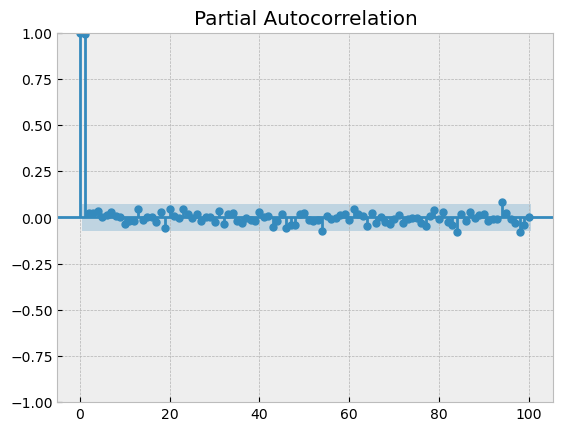

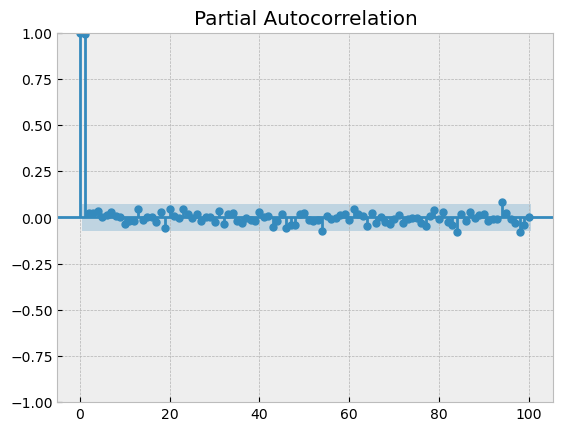

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags=100, method='ywm')

## 4. Modellbildung und -anpassung

ARIMA ist ein gebräuchlicher Algorithmus für die Vorhersage von Zeitreihen. Er basiert auf drei zentralen Parametern:

- `p` steht für die Anzahl der zurückliegenden Datenpunkte, die berücksichtigt werden, um den nächsten Punkt zu prognostizieren. Dies ist der autoregressive Aspekt des Modells.
- `d` repräsentiert die notwendigen Differenzbildungen, um die Zeitreihe stationär zu machen. Dies ist der integrierte Aspekt des Modells.
- `q` bezieht sich auf die Anzahl der vorhergehenden Fehler, die in das Modell einfließen. Dies ist der gleitende Durchschnittsaspekt des Modells.

In der Funktion `auto_arima` wird das 'Close'-Feld aus unseren Börsendaten als eindimensionales Array übergeben. Die Funktion probiert verschiedene Kombinationen von `p`, `d` und `q` aus und wählt diejenige aus, die das beste Modell ergibt (das heißt, das Modell mit dem niedrigsten AIC-Wert).

Die Einstellung `seasonal=False` teilt dem Modell mit, dass es keine saisonalen Komponenten berücksichtigen soll, während `trace=True` bewirkt, dass der Fortschritt der Funktion während der Ausführung angezeigt wird.

Zum Schluss werden die optimalen Werte für `p`, `d` und `q` ausgegeben und in den entsprechenden Variablen gespeichert.

In [6]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima

# Annahme: Sie haben Ihre Zeitreihendaten in einem DataFrame namens 'data' geladen

# Die Zeitreihendaten in eine eindimensionale NumPy-Array-ähnliche Struktur umwandeln
y = np.array(data['Close'])

# AutoARIMA-Modell erstellen und anpassen, um die optimalen Parameterwerte zu ermitteln
model = auto_arima(y, seasonal=False, trace=True)

# Die optimalen Parameterwerte für P, D und Q ausgeben
print(f"Optimale Werte für P, D und Q: {model.order}")
p, d, q = model.order


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3332.818, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3327.677, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3329.394, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3329.379, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3326.341, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3328.865, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.330 seconds
Optimale Werte für P, D und Q: (0, 1, 0)


Es wurden verschiedene Kombinationen von P, D und Q getestet und dabei jeweils den AIC (Akaike Information Criterion) berechnet. Die AIC ist eine Maßzahl für die Güte eines statistischen Modells: Je kleiner der AIC-Wert, desto besser passt das Modell zu den Daten, wenn man die Komplexität des Modells mit einbezieht.

Im gegebenen Fall war das beste Modell ARIMA(0,1,0), weil es den niedrigsten AIC-Wert hatte (3679.890). Die optimalen Werte für P, D und Q waren also 0, 1 und 0. Dies bedeutet:

    P (Ordnung des autoregressiven Teils): 0 – Es werden keine vorherigen Datenpunkte zur Vorhersage des nächsten Punktes verwendet.
    D (Integrationsgrad): 1 – Die Zeitreihe wurde einmal differenziert, um sie stationär zu machen.
    Q (Ordnung des gleitenden Durchschnitts): 0 – Es werden keine vorherigen Fehler in das Modell einbezogen.

In [7]:
#predictions = fitted.predict()
#print(predictions)

SARIMAX wird verwendet, um ein saisonales autoregressives, integriertes gleitendes Durchschnittsmodell (Seasonal AutoRegressive Integrated Moving Average, SARIMA) zu erstellen und an die Daten anzupassen. Dies ist eine Erweiterung des ARIMA-Modells, das die saisonale Komponente in den Daten berücksichtigt.

Es werden 4 Parameter übernommen: die Zeitreihendaten, die Ordnung des Modells (p, d und q), und die saisonale Ordnung des Modells. Hier sind die Schlusskurse ('Close') aus den Aktiendaten die Zeitreihendaten und die durch auto_arima ermittelten optimalen Werte werden als Ordnung des Modells und der saisonalen Ordnung übergeben. Die Zahl 12 in der saisonalen Ordnung bedeutet, dass die Saisonalität auf jährlicher Basis betrachtet wird (12 Monate).

In [8]:
import statsmodels.api as sm
import warnings
import time

# Startzeit messen
start_time = time.time()

model = sm.tsa.statespace.SARIMAX(data['Close'],
                                 order=(p, d, q),
                                 seasonal_order=(p, d, q, 12))
model = model.fit()

# Endzeit messen
end_time = time.time()

# Gesamtdauer berechnen
duration = end_time - start_time

print(model.summary())
print("Durchlaufdauer:", duration, "Sekunden")

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  755
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1914.009
Date:                            Tue, 11 Jul 2023   AIC                           3830.018
Time:                                    02:15:02   BIC                           3834.627
Sample:                                         0   HQIC                          3831.795
                                            - 755                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        10.1876      0.421     24.209      0.000       9.363      11.012
Ljung-Box (L1) (Q):                

## 5. Vorhersagen

Es wird eine Vorhersage für die nächsten 30 Tage gemacht.

Zuerst werden zukünftige Daten generiert, indem ein `pd.date_range`-Objekt erstellt wird, das mit dem Tag nach dem letzten Datum in den Daten beginnt und für die nächsten 30 Tage andauert.

Ein neuer DataFrame `df_predictions` wird erstellt, der die zukünftigen Daten und die entsprechenden Vorhersagen enthält.

Dann wird dieser neue DataFrame an den ursprünglichen DataFrame angehängt, um einen erweiterten DataFrame `data_extended` zu erstellen, der sowohl die ursprünglichen Daten als auch die Vorhersagen enthält.

Anschließend wird ein Plot erstellt, der die Schlusskurse mit Datum abbildet. Die ursprüngliche Zeitreihe wird zusammen mit den Vorhersagen für die nächsten 30 Tage gezeichnet. 

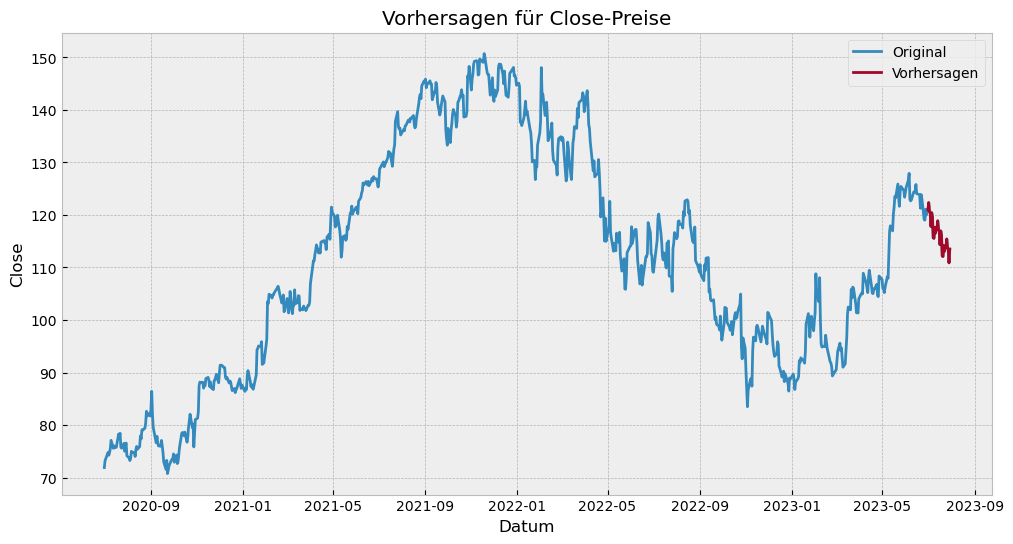

In [9]:
# Vorhersagen für die nächsten 30 Tage erhalten
predictions = model.predict(len(data), len(data) + 29)  # 30 Tage Vorhersagen

# Daten für die nächsten 30 Tage generieren
future_dates = pd.date_range(start=data['Date'].iloc[-1] + timedelta(days=1), periods=30)

# Ein DataFrame für die Vorhersagen erstellen
df_predictions = pd.DataFrame({
    'Date': future_dates,
    'Close': predictions
})

# DataFrame erweitern, indem Sie die Vorhersagen anhängen
data_extended = pd.concat([data, df_predictions])

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(data_extended['Date'], data_extended['Close'], label='Original')
plt.plot(data_extended['Date'].tail(30), data_extended['Close'].tail(30), label='Vorhersagen')
plt.xlabel('Datum')
plt.ylabel('Close')
plt.title('Vorhersagen für Close-Preise')
plt.legend()
plt.grid(True)
plt.show()

## 7. Datenbankaktualisierung

In nächsten Schritt werden neue Spalten zum `data_extended` DataFrame hinzugefügt, um zusätzliche Informationen über das Unternehmen, den Datentyp und einen eindeutigen Schlüssel zu speichern.

Die 'Company' Spalte wird mit dem Unternehmensnamen gefüllt, der aus dem ursprünglichen DataFrame extrahiert wurde.

Die 'Type' Spalte wird erstellt, um zu unterscheiden, ob die Daten tatsächliche Daten ('Act_') oder Vorhersagedaten ('Arima_') sind. Die Funktion `apply` wird auf die 'High' Spalte angewendet und die Funktion `lambda` überprüft, ob der Wert `nan` ist. Wenn er `nan` ist (was bei den vorhergesagten Daten der Fall sein sollte, da nur die 'Close' Preise vorhergesagt wurden), wird 'Arima_' vorangestellt. Ansonsten wird 'Act_' vorangestellt. Anschließend wird der Unternehmensname angehängt.

Die 'Forecast_Date' Spalte wird mit dem Wert von `end_date` gefüllt, aber nur für die Zeilen, in denen 'Type' 'Arima_' enthält, was bedeutet, dass es sich um Vorhersagedaten handelt.

Schließlich wird eine 'Key' Spalte erstellt, die eine Kombination aus 'Company', 'Date' und 'Type' ist. Diese dient als eindeutiger Identifikator für jede Zeile.

Diese Spalten werden hinzugefügt, um zusätzliche Informationen zu speichern und die Datenorganisation und -zugriff zu erleichtern.

In [10]:
import numpy as np

# Key einbinden
company = data.loc[0]['Company']
data_extended['Company'] = company
data_extended['Type'] = data_extended['High'].apply(lambda x: f'Arima_{company}' if np.isnan(x) else f'Act_{company}')
data_extended.loc[data_extended['Type'].str.contains('Arima'), 'Forecast_Date'] = end_date
data_extended['Key'] = data_extended['Company'] + '_' + data_extended['Date'].astype(str) + '_' + data_extended['Type']


Es wird eine Verbindung zu einer SQL Server Datenbank hergestellt und die Daten aus der Tabelle `stock_data_forecast` in einen DataFrame geladen. Außerdem wird eine neue Spalte 'Key' zu diesem DataFrame hinzugefügt, die einen eindeutigen Identifikator für jede Zeile darstellt.

Zuerst werden die notwendigen Bibliotheken importiert und die Pandas-Warnungen deaktiviert, um den Code sauberer aussehen zu lassen.

Ein Verbindungsstring zur Datenbank wird erstellt und eine Verbindung zur Datenbank hergestellt. Mit der `create_engine` Funktion von SQLAlchemy wird ein 'connectable' erstellt, das mit der pyodbc-Verbindung arbeitet.

Dann wird eine SQL-Abfrage definiert, um alle Daten aus der Tabelle `stock_data_forecast` zu holen, die gleich benötigt wird. Das Ergebnis wird in ein DataFrame `exists_df` geladen.

Anschließend werden noch Angleichung durchgeführt.

In [11]:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings

# Deaktivieren der Pandas-Warnungen
warnings.filterwarnings('ignore', category=UserWarning)

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Query erstellen, um alle Daten auszulesen
query = "SELECT * FROM stock_data_forecast"

# Ausführen der Query und Laden der Ergebnisse in einen DataFrame
exists_df = pd.read_sql(query, cnxn)

# added
exists_df = exists_df.astype(data_extended.dtypes)
exists_df = exists_df.reindex(columns=data_extended.columns)

# Key einbinden
exists_df['Key'] = exists_df['Company'] + '_' + exists_df['Date'].astype(str) + '_' + exists_df['Type']

Im nächsten Schritt werden die Forecast-Daten mit den in der SQL-Datenbank enthaltenen Daten zusammengeführt und die Duplikate werden entfernt. Abschließend werden die übrigen Daten in die Datenbank geschrieben.

In [12]:
# Zusammenführen der beiden DataFrames
combined_df = pd.concat([exists_df, data_extended])

# Entfernen von Duplikaten
combined_df = combined_df.drop_duplicates(subset=['Key'], keep=False)

# Schreiben des aktualisierten DataFrames in die SQL Server-Tabelle
combined_df.to_sql('stock_data_forecast', con=engine, if_exists='append', index=False)

# Anzahl der geschriebenen Zeilen erhalten
num_written_rows = combined_df.shape[0]
print(f"Es wurden {num_written_rows} Zeilen erfolgreich übertragen.")

exists_df = pd.read_sql('SELECT * FROM stock_data_forecast', cnxn)
exists_df.drop_duplicates(subset='Key', inplace=True)

# Verbindung schließen
cnxn.close()
print(f"Die Verbindung ist wieder geschlossen.")

Es wurden 1659 Zeilen erfolgreich übertragen.
Die Verbindung ist wieder geschlossen.


In [13]:
# Darstellung der übertragenen Daten
combined_df

,ID,Date,Company,Type,Open,High,Low,Close,Volume,Forecast_Date,Key
0,137.0,2021-01-15,AAPL,Act_AAPL,128.78,130.22,127.00,127.139999,111599000.0,None,AAPL_2021-01-15_Act_AAPL
1,138.0,2021-01-19,AAPL,Act_AAPL,127.78,128.71,126.94,127.830002,90757300.0,None,AAPL_2021-01-19_Act_AAPL
2,139.0,2021-01-20,AAPL,Act_AAPL,128.66,132.49,128.55,132.029999,104320000.0,None,AAPL_2021-01-20_Act_AAPL
3,140.0,2021-01-21,AAPL,Act_AAPL,133.80,139.67,133.59,136.869995,120151000.0,None,AAPL_2021-01-21_Act_AAPL
4,141.0,2021-01-22,AAPL,Act_AAPL,136.28,139.85,135.02,139.070007,114459000.0,None,AAPL_2021-01-22_Act_AAPL
...,...,...,...,...,...,...,...,...,...,...,...
780,NaN,2023-07-26,GOOG,Arima_GOOG,NaN,NaN,NaN,115.410004,NaN,2023-07-01,GOOG_2023-07-26_Arima_GOOG
781,NaN,2023-07-27,GOOG,Arima_GOOG,NaN,NaN,NaN,113.680000,NaN,2023-07-01,GOOG_2023-07-27_Arima_GOOG
782,NaN,2023-07-28,GOOG,Arima_GOOG,NaN,NaN,NaN,113.470001,NaN,2023-07-01,GOOG_2023-07-28_Arima_GOOG
783,NaN,2023-07-29,GOOG,Arima_GOOG,NaN,NaN,NaN,110.880005,NaN,2023-07-01,GOOG_2023-07-29_Arima_GOOG
